## Data Collection and Overview

In [ ]:
from google_play_scraper import reviews, Sort
import pandas as pd
import time

APP_ID = "com.infoldgames.infinitynikkien"
TARGET = 1000
BATCH = 200
all_reviews = []

cursor = None
while len(all_reviews) < TARGET:
    cnt = min(BATCH, TARGET - len(all_reviews))
    result, cursor = reviews(
        APP_ID,
        lang='en',
        country='us',
        sort=Sort.NEWEST,
        count=cnt,
        continuation_token=cursor
    )
    if not result:
        break
    all_reviews.extend(result)
    print("collected:", len(all_reviews))
    time.sleep(1)

df = pd.DataFrame(all_reviews)
df = df[['reviewId','content','score','at','thumbsUpCount']]
df.to_csv("infinity_nikki_1000_reviews.csv", index=False)
print("saved")

collected: 200
collected: 400
collected: 600
collected: 800
collected: 1000
saved


In [2]:
df = df[['content','score']]
df.head()

,content,score
0,The game is good and I'll give it a 5 stars bu...,5
1,game won't even open anymore as of late last w...,1
2,I was walking back from my evening lecture acr...,4
3,"i love the game, but infold does always push w...",1
4,i know that its an amazing game but when i dow...,5


## Rating Adjustments and Labeling

Convert ratings 1 - 5 into binary (positive/negative). 1 - 2 for negative, 4 - 5 for positive, and handle 3-star reviews using VADER (sentiment check)

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
def analyze_sentiment(data):
    analysis = SIA().polarity_scores(data)
    if analysis['compound'] > 0:
        return 'Positive'
    elif analysis['compound'] == 0:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment_neutral_ratings'] = df[df.score == 3].content.apply(analyze_sentiment)
df[df.score == 3].head()

,content,score,sentiment_neutral_ratings
5,مهم نیست این بازی چقدر عالیه از اینکه مجبورم د...,3,Neutral
14,"I really like the game, the story and the outf...",3,Positive
22,The variety of clothes and the beautiful world...,3,Positive
26,It's a beautiful game but why is it so laggy w...,3,Positive
34,The game is actually so beautiful but the fact...,3,Positive


In [4]:
df[df.sentiment_neutral_ratings == 'Neutral'].head()

,content,score,sentiment_neutral_ratings
5,مهم نیست این بازی چقدر عالیه از اینکه مجبورم د...,3,Neutral
101,why don't l get to choose my identity 🆔,3,Neutral
461,This game has a lot of up and downs....,3,Neutral
499,ما قدرت اجربها لأن اللعبة محتاجه تحديث يتحمل م...,3,Neutral
511,so many scenes,3,Neutral


In [5]:
df = df[df.sentiment_neutral_ratings != 'Neutral']

In [6]:
def rating_seg(row):
    if row['score'] <= 2:
        return 0
    elif row['score'] == 3:
        return 1 if row['sentiment_neutral_ratings'] == 'Positive' else 0
    else:
        return 1


df['new_score'] = df.apply(rating_seg, axis=1)
df[['score','new_score']].sample(frac=1.0).head()

,score,new_score
967,5,1
506,1,0
901,5,1
133,1,0
91,5,1


Double check transformation

In [7]:
df.drop(['sentiment_neutral_ratings'],inplace=True,axis=1)

Drop neutral sentiment reviews

## Exploratory Data Analysis

### Top Words per Rating

In [8]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

for rating in sorted(df['score'].unique()):
    words = ' '.join(df[df['score']==rating]['content']).split()
    common = Counter(words).most_common(10)
    print(f'Rating {rating}: {common}')

Rating 1: [('the', 792), ('to', 493), ('and', 466), ('I', 461), ('game', 397), ('it', 340), ('a', 293), ('this', 237), ('is', 228), ('on', 206)]
Rating 2: [('the', 208), ('to', 130), ('I', 116), ('and', 111), ('game', 89), ('it', 85), ('but', 69), ('this', 59), ('a', 57), ('is', 50)]
Rating 3: [('the', 230), ('to', 121), ('and', 109), ('I', 105), ('a', 79), ('game', 78), ('it', 72), ('is', 71), ('but', 61), ('of', 49)]
Rating 4: [('the', 153), ('and', 87), ('I', 82), ('to', 73), ('a', 71), ('game', 69), ('is', 63), ('it', 52), ('but', 38), ('of', 36)]
Rating 5: [('the', 278), ('I', 235), ('and', 223), ('game', 172), ('to', 161), ('a', 133), ('is', 124), ('this', 112), ('it', 106), ('love', 86)]


Find top words per rating. We find that there are a lot of stopwords

### Reviews Lengths

In [9]:
df['length'] = df['content'].apply(lambda x: len(str(x)))
df['length'].describe()

count    990.000000
mean     196.327273
std      164.109843
min        2.000000
25%       52.000000
50%      144.500000
75%      328.500000
max      500.000000
Name: length, dtype: float64

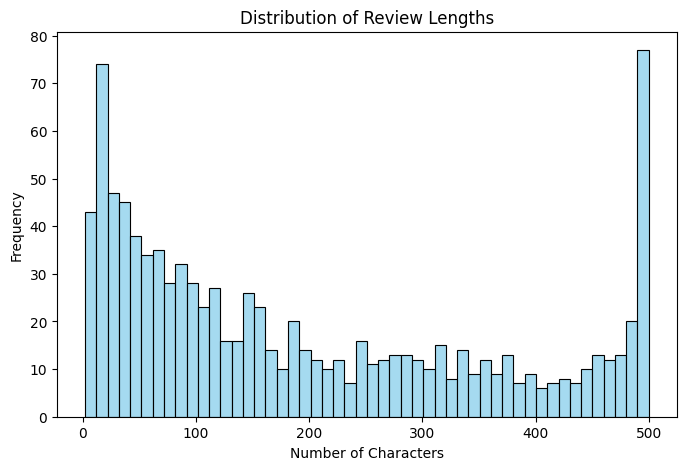

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(df['length'], bins=50, color='skyblue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

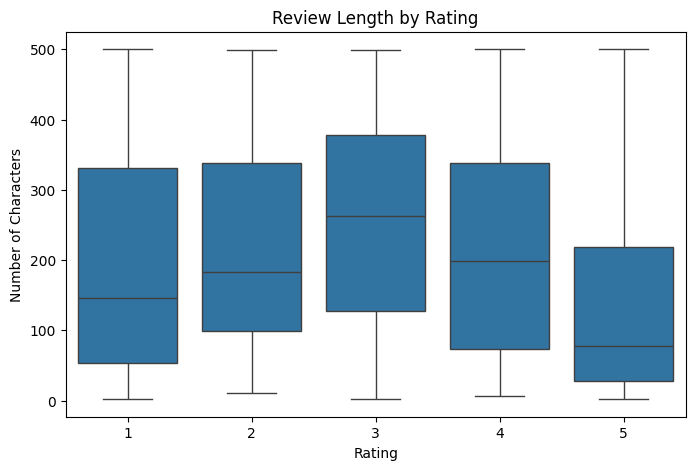

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(x='score', y='length', data=df)
plt.title('Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Characters')
plt.show()

Longest review at 500 characters and shortest at 2 characters. The average review has 196 characters. Reviews tend to be more neutral and negative the longer it is

### Rating Distribution

<Axes: xlabel='score', ylabel='count'>

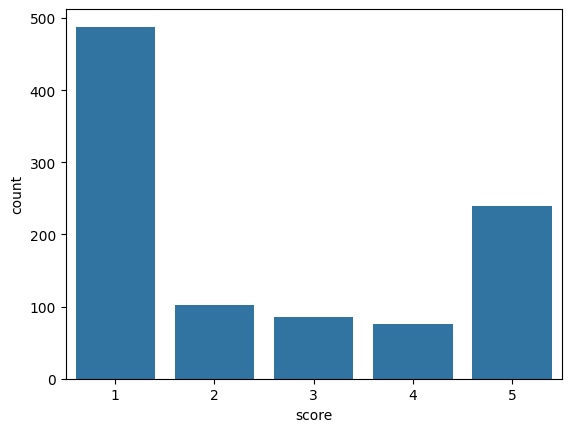

In [12]:
sns.barplot(x = df.score.value_counts().index, y = df.score.value_counts())

Reviews are mainly 1 star which will cause imbalance/bias

## Data Preprocessing

Check for null data

In [13]:
df.isnull().sum()

content      0
score        0
new_score    0
length       0
dtype: int64

In [14]:
df['content'].head()

0    The game is good and I'll give it a 5 stars bu...
1    game won't even open anymore as of late last w...
2    I was walking back from my evening lecture acr...
3    i love the game, but infold does always push w...
4    i know that its an amazing game but when i dow...
Name: content, dtype: object

Make a new column for the new reviews that will be preprocessed. Convert reviews to lowercase

In [15]:
df['new_content'] = df['content'].astype(str).str.lower()
df[['content','new_content']].head()

,content,new_content
0,The game is good and I'll give it a 5 stars bu...,the game is good and i'll give it a 5 stars bu...
1,game won't even open anymore as of late last w...,game won't even open anymore as of late last w...
2,I was walking back from my evening lecture acr...,i was walking back from my evening lecture acr...
3,"i love the game, but infold does always push w...","i love the game, but infold does always push w..."
4,i know that its an amazing game but when i dow...,i know that its an amazing game but when i dow...


Replace non-alphabet characters with space. First by checking for reviews that have non-alphabet character

In [16]:
df.loc[df['new_content'].str.contains("[^a-z\s]"),'new_content'].head()

0    the game is good and i'll give it a 5 stars bu...
1    game won't even open anymore as of late last w...
2    i was walking back from my evening lecture acr...
3    i love the game, but infold does always push w...
4    i know that its an amazing game but when i dow...
Name: new_content, dtype: object

Then, replacing it with space

In [17]:
df['new_content'] = df['new_content'].str.replace(r'[^a-zA-Z\s]', ' ', regex=True)
df[['content','new_content']].head()

,content,new_content
0,The game is good and I'll give it a 5 stars bu...,the game is good and i ll give it a stars bu...
1,game won't even open anymore as of late last w...,game won t even open anymore as of late last w...
2,I was walking back from my evening lecture acr...,i was walking back from my evening lecture acr...
3,"i love the game, but infold does always push w...",i love the game but infold does always push w...
4,i know that its an amazing game but when i dow...,i know that its an amazing game but when i dow...


Double checking for reviews that may still have non-alphabet characters

In [18]:
df.loc[df['new_content'].str.contains("[^a-z\s]"),'new_content']

Series([], Name: new_content, dtype: object)

Check for reviews with double or more spaces

In [19]:
df.loc[df['new_content'].str.contains("\s{2,}"),'new_content'].head()

0    the game is good and i ll give it a   stars bu...
1    game won t even open anymore as of late last w...
2    i was walking back from my evening lecture acr...
3    i love the game  but infold does always push w...
4    i know that its an amazing game but when i dow...
Name: new_content, dtype: object

We can notice that after removing non-alphabet characters, we have double or more spaces in some reviews. Remove the extra spaces

In [20]:
df['new_content'] = df['new_content'].str.replace(r'\s+', ' ', regex=True).str.strip()
df.loc[df['new_content'].str.contains("\s{2,}"),'new_content'].head()

Series([], Name: new_content, dtype: object)

Tokenize and removing stop words

In [21]:
from nltk.tokenize import word_tokenize
df['new_content'] = df['new_content'].apply(word_tokenize)

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['new_content'] = df['new_content'].apply(lambda toks: [w for w in toks if w not in stop_words])

df[['content','new_content']].head()

,content,new_content
0,The game is good and I'll give it a 5 stars bu...,"[game, good, give, stars, suggestion, improve,..."
1,game won't even open anymore as of late last w...,"[game, even, open, anymore, late, last, week, ..."
2,I was walking back from my evening lecture acr...,"[walking, back, evening, lecture, across, camp..."
3,"i love the game, but infold does always push w...","[love, game, infold, always, push, nudging, mo..."
4,i know that its an amazing game but when i dow...,"[know, amazing, game, download, needs, lot, ti..."


Lemmatize

In [22]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

df['new_content'] = df['new_content'].apply(lambda x: [WordNetLemmatizer().lemmatize(word) for word in x])

Drop reviews with less than 1 word

In [23]:
df = df[df['new_content'].map(len) > 1]
df[df['new_content'].map(lambda x: len(x)) < 2].head()

,content,score,new_score,length,new_content


## Text Representation

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_vect = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True
)
Train_content_tfidf = Tfidf_vect.fit_transform([' '.join(tokens) for tokens in df['new_content']])

### Word2Vec

In [26]:
from gensim.models import Word2Vec
import numpy as np

tokens = df['new_content'].tolist()
w2v = Word2Vec(sentences=tokens, vector_size=200, window=5, min_count=2, sg=1, workers=4, epochs=10)

def avg_vec(words):
    vecs = [w2v.wv[w] for w in words if w in w2v.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v.vector_size)

x_w2v = np.vstack([avg_vec(ws) for ws in tokens])

### Hyperparameter Tuning

In [28]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_lr = {
    'C': [0.1, 0.5, 1, 2, 5, 10],
    'penalty': ['l1', 'l2']
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', random_state=42),
    param_grid_lr,
    cv=SKF, scoring='f1_macro', n_jobs=-1
)
grid_lr.fit(Train_content_tfidf, df['new_score'])
print("Best LogisticRegression TF-IDF:", grid_lr.best_params_, "F1:", grid_lr.best_score_)

param_grid_svc = {
    'C': [0.1, 0.5, 1, 2, 5, 10],
    'loss': ['hinge', 'squared_hinge']
}

grid_svc = GridSearchCV(
    LinearSVC(class_weight='balanced', random_state=42),
    param_grid_svc,
    cv=SKF, scoring='f1_macro', n_jobs=-1
)
grid_svc.fit(Train_content_tfidf, df['new_score'])
print("Best LinearSVC TF-IDF:", grid_svc.best_params_, "F1:", grid_svc.best_score_)

Best LogisticRegression TF-IDF: {'C': 2, 'penalty': 'l2'} F1: 0.8020897305756816
Best LinearSVC TF-IDF: {'C': 0.1, 'loss': 'squared_hinge'} F1: 0.8029958660505393


### Training

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

# CV & target
y = df['new_score']

def eval_row(name, y_true, y_pred):
    p,r,f1,_ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return dict(Model=name,
                Accuracy=accuracy_score(y_true, y_pred),
                Precision=p, Recall=r, F1=f1)

tfidf_models = [
    ("TFIDF + LogisticRegression", LogisticRegression(
        C=2, penalty='l2', solver='liblinear',
        max_iter=1000, class_weight='balanced', random_state=42)),

    ("TFIDF + LinearSVC", LinearSVC(
        C=0.1, loss='squared_hinge',
        class_weight='balanced', random_state=42)),
]

w2v_models = [
    ("Word2Vec + LogisticRegression", Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            C=2, penalty='l2',
            max_iter=1000, class_weight='balanced', random_state=42))
    ])),
    ("Word2Vec + LinearSVC", Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LinearSVC(
            C=0.1, loss='squared_hinge',
            class_weight='balanced', random_state=42))
    ])),
]

In [30]:
from sklearn.model_selection import cross_validate

scoring = {
    'acc': 'accuracy',
    'prec': 'precision_macro',
    'rec': 'recall_macro',
    'f1':  'f1_macro'
}

def cv_row(name, clf, X, y, cv):
    scores = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    return dict(
        Model=name,
        Accuracy=scores['test_acc'].mean(),
        Precision=scores['test_prec'].mean(),
        Recall=scores['test_rec'].mean(),
        F1=scores['test_f1'].mean()
    )

rows = []

for name, clf in tfidf_models:
    rows.append(cv_row(name, clf, Train_content_tfidf, y, SKF))

for name, clf in w2v_models:
    rows.append(cv_row(name, clf, x_w2v, y, SKF))

summary = pd.DataFrame(rows).sort_values('F1', ascending=False)
summary[['Model','Accuracy','Precision','Recall','F1']].round(4)

,Model,Accuracy,Precision,Recall,F1
1,TFIDF + LinearSVC,0.8223,0.8142,0.7972,0.8030
0,TFIDF + LogisticRegression,0.8212,0.8132,0.7970,0.8021
3,Word2Vec + LinearSVC,0.7366,0.7198,0.7261,0.7209
2,Word2Vec + LogisticRegression,0.7334,0.7163,0.7235,0.7178


In [31]:
table = []

table.append(['TF-IDF', 'LogisticRegression', 'C=2, penalty=l2', summary.loc[summary.Model=='TFIDF + LogisticRegression',['Accuracy','Precision','Recall','F1']].values[0].tolist()])
table.append(['TF-IDF', 'LinearSVC', 'C=0.1, loss=squared_hinge', summary.loc[summary.Model=='TFIDF + LinearSVC',['Accuracy','Precision','Recall','F1']].values[0].tolist()])
table.append(['Word2Vec', 'LogisticRegression', 'C=2, penalty=l2', summary.loc[summary.Model=='Word2Vec + LogisticRegression',['Accuracy','Precision','Recall','F1']].values[0].tolist()])
table.append(['Word2Vec', 'LinearSVC', 'C=0.1, loss=squared_hinge', summary.loc[summary.Model=='Word2Vec + LinearSVC',['Accuracy','Precision','Recall','F1']].values[0].tolist()])

df_summary6 = pd.DataFrame(
    [[t[0], t[1], t[2], *t[3]] for t in table],
    columns=['Text Representation','ML Algorithm','Hyperparameter',
             'Metric Evaluation 1 (Accuracy)',
             'Metric Evaluation 2 (Precision)',
             'Metric Evaluation 3 (Recall)',
             'Metric Evaluation 4 (F1-score)']
)

df_summary6

,Text Representation,ML Algorithm,Hyperparameter,Metric Evaluation 1 (Accuracy),Metric Evaluation 2 (Precision),Metric Evaluation 3 (Recall),Metric Evaluation 4 (F1-score)
0,TF-IDF,LogisticRegression,"C=2, penalty=l2",0.821206,0.813171,0.797006,0.802090
1,TF-IDF,LinearSVC,"C=0.1, loss=squared_hinge",0.822270,0.814209,0.797172,0.802996
2,Word2Vec,LogisticRegression,"C=2, penalty=l2",0.733362,0.716303,0.723511,0.717770
3,Word2Vec,LinearSVC,"C=0.1, loss=squared_hinge",0.736576,0.719775,0.726076,0.720854


TF-IDF with LinearSVC/LogisticRegression achieved the best performance (~0.80 macro-F1), outperforming Word2Vec (~0.71–0.73 macro-F1), indicating that sparse term-weight features capture sentiment cues more effectively in this dataset. Hyperparameter tuning (C and penalty/loss) improved stability and increased F1 by 0.04.